In [1]:
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from datasets import ImageDataset, Rescale, ToTensor
from model import UISNet
from config import *
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
batch_size = 4

dataset = ImageDataset(root_dir=im_folder, 
                                  transform=transforms.Compose([
                                      Rescale((height, width)), 
                                      ToTensor()
                                  ]))

dataloader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

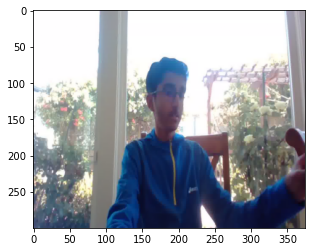

In [3]:
def plot_rgb(img):
    plt.imshow(img.numpy().transpose((1, 2, 0)))
    plt.show()

for batch in dataloader:
    plot_rgb(batch[0])
    break

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
model = UISNet(maxPixelFeatures, nMidConvs).to(device)

In [6]:
optimizer = optim.Adam(model.parameters(), lr=0.1)

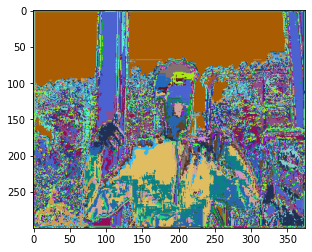

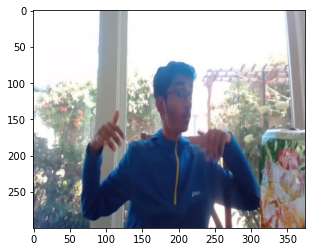

In [7]:
label_colours = np.random.randint(255,size=(maxPixelFeatures,3))

def plot_segmented(output):
    output = output.permute(1, 2, 0).contiguous().view(-1, maxPixelFeatures)
    _, target = torch.max(output, 1)
    im_target = target.data.cpu().numpy()
    im_target_rgb = np.array([label_colours[c % maxPixelFeatures] for c in im_target])
    im_target_rgb = im_target_rgb.reshape((height, width, 3)).astype(np.uint8)
    plt.imshow(im_target_rgb)
    plt.show()

for batch in dataloader:
    batch = batch.to(device)
    output = model(batch)[0]
    plot_segmented(output)
    plot_rgb(batch[0])
    break

In [8]:
from IPython import display

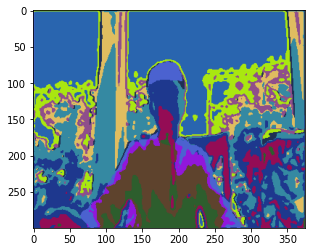

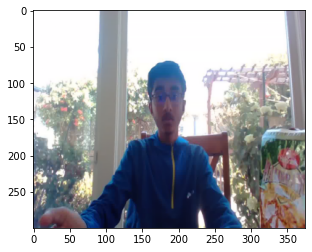

18 / 41 | label num : 12 | loss : 0.19351626932621002 | epoch: 1


In [9]:
L_sim = nn.CrossEntropyLoss()
mu = 1
maxEpochs = 4
done = False

model.train()
for epoch in range(maxEpochs):
    for i_batch, batch in enumerate(dataloader):
        optimizer.zero_grad()

        batch = batch.to(device)
        output = model(batch)

        output_sim = output.permute(0, 2, 3, 1).contiguous().view(-1, maxPixelFeatures)
        ignore, target = torch.max(output, 1)
        loss_sim = L_sim(output, target)

        output_con = output.permute(0, 2, 3, 1)
        loss_hori = torch.mean(torch.abs(output_con[:, 0:-1, 1:, :] - output_con[:, 0:-1, :-1, :]))
        loss_vert = torch.mean(torch.abs(output_con[:, 1:, 0:-1, :] - output_con[:, 0:-1, 0:-1, :]))

        loss = loss_sim + mu * (loss_hori + loss_vert)

        loss.backward()
        optimizer.step()

        plot_segmented(output[0])
        plot_rgb(batch[0])

        im_target = target.data.cpu().numpy()
        nLabels = len(np.unique(im_target))
        print (i_batch+1, '/', len(dataloader), '|', 'label num :', nLabels, '| loss :', loss.item(), '| epoch:', epoch+1)

        if nLabels < minPixelFeatures:
            done = True
            break

        display.clear_output(wait=True)
    torch.save(model.state_dict(), im_folder + '.pt')
    if done:
        break

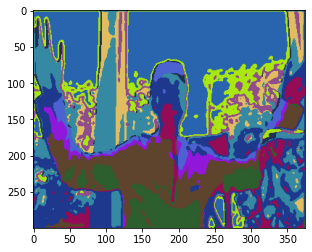

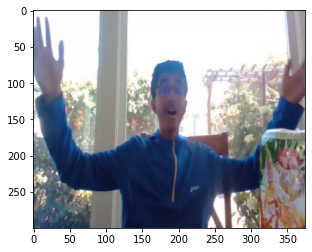

In [10]:
# Run over and over to get random images and the model's prediction
for batch in dataloader:
    batch = batch.to(device)
    output = model(batch)[0]
    plot_segmented(output)
    plot_rgb(batch[0])
    break